## Descriptive Statistics

Imports and settings

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 60)
plt.rcParams['figure.figsize'] = (10,5)


Load the dataset

In [10]:
df = pd.read_csv('../data/raw_analyst_ratings.csv', parse_dates=['date'], keep_default_na=False)
df.shape, df.head(3)


((1407328, 6),
    Unnamed: 0                                    headline  \
 0           0     Stocks That Hit 52-Week Highs On Friday   
 1           1  Stocks That Hit 52-Week Highs On Wednesday   
 2           2               71 Biggest Movers From Friday   
 
                                                  url          publisher  \
 0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
 1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
 2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
 
                         date stock  
 0  2020-06-05 10:30:54-04:00     A  
 1  2020-06-03 10:45:20-04:00     A  
 2  2020-05-26 04:30:07-04:00     A  )

Timezone & basic cleaning (dataset uses UTC-4)

In [16]:
# Ensure datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Convert timezone correctly (because it's already tz-aware)
df['date_local'] = df['date'].dt.tz_convert('Etc/GMT+4')

# Convert back to UTC if needed
df['date_utc'] = df['date_local'].dt.tz_convert('UTC')

# Normalize tickers and publisher
df['stock'] = df['stock'].str.upper().str.strip()
df['publisher'] = df['publisher'].replace('', pd.NA)
# Drop rows with no headline or stock
df = df.dropna(subset=['headline','stock'])


Descriptive stats: headline length & token counts

In [17]:
df['headline_len_chars'] = df['headline'].str.len()
df['headline_word_count'] = df['headline'].str.split().str.len()

df[['headline_len_chars','headline_word_count']].describe()


,headline_len_chars,headline_word_count
count,1.407328e+06,1.407328e+06
mean,7.312051e+01,1.141671e+01
std,4.073531e+01,6.352997e+00
min,3.000000e+00,1.000000e+00
25%,4.700000e+01,7.000000e+00
50%,6.400000e+01,1.000000e+01
75%,8.700000e+01,1.300000e+01
max,5.120000e+02,7.700000e+01


Plot histogram and boxplot:

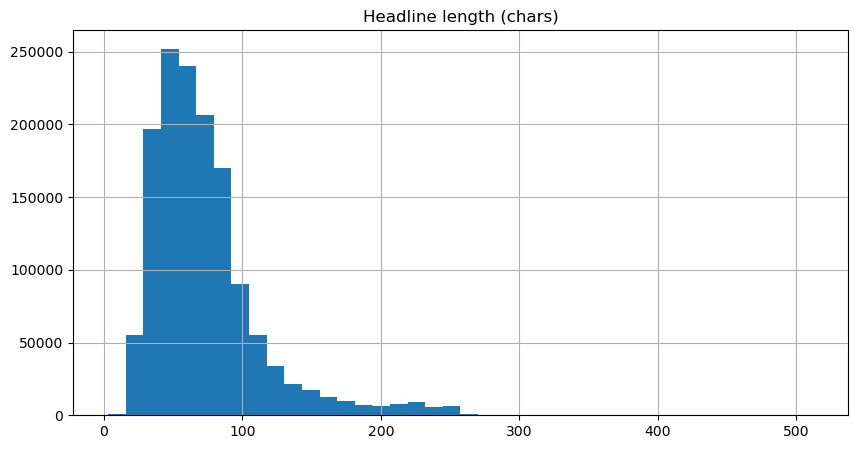

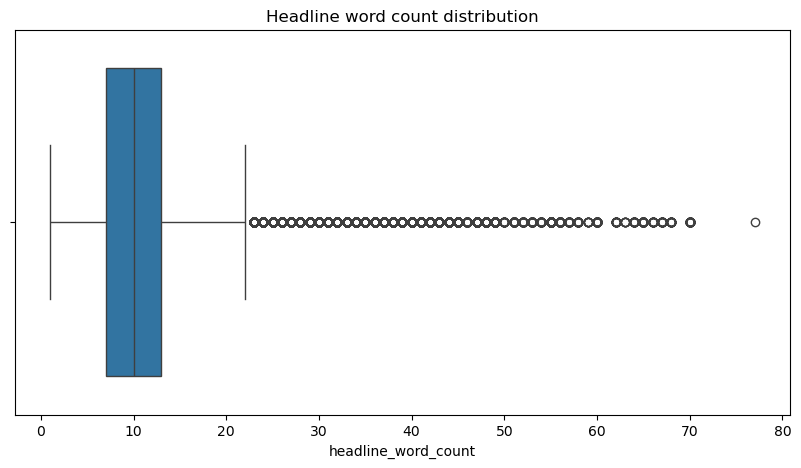

In [18]:
df['headline_len_chars'].hist(bins=40)
plt.title('Headline length (chars)')
plt.show()

sns.boxplot(x=df['headline_word_count'])
plt.title('Headline word count distribution')
plt.show()


Publisher counts (top contributors)

In [19]:
publisher_counts = df['publisher'].value_counts(dropna=False).reset_index()
publisher_counts.columns = ['publisher','count']
publisher_counts.head(20)


,publisher,count
0,Paul Quintaro,228373
1,Lisa Levin,186979
2,Benzinga Newsdesk,150484
3,Charles Gross,96732
4,Monica Gerson,82380
5,Eddie Staley,57254
6,Hal Lindon,49047
7,ETF Professor,28489
8,Juan Lopez,28438
9,Benzinga Staff,28114


Plot top 10:

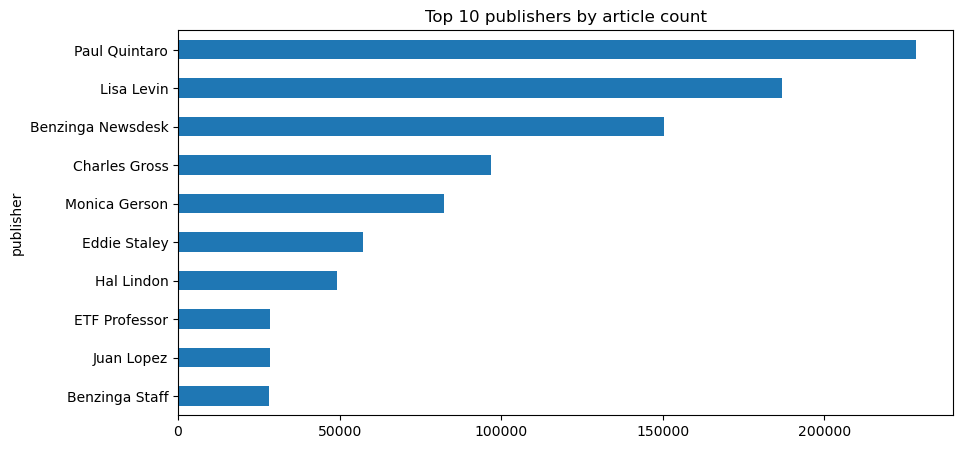

In [20]:
publisher_counts.head(10).set_index('publisher')['count'].plot(kind='barh')
plt.title('Top 10 publishers by article count')
plt.gca().invert_yaxis()
plt.show()


Publication trends over time

Daily counts:

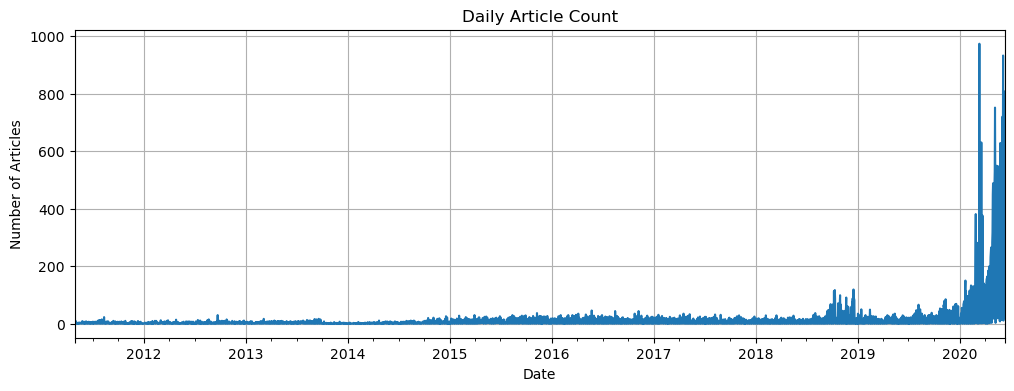

In [34]:
daily_counts = df.resample('D', on='date_utc').size().rename('daily_count')

daily_counts.plot(figsize=(12,4))
plt.title('Daily Article Count')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.show()

Weekly rolling mean:

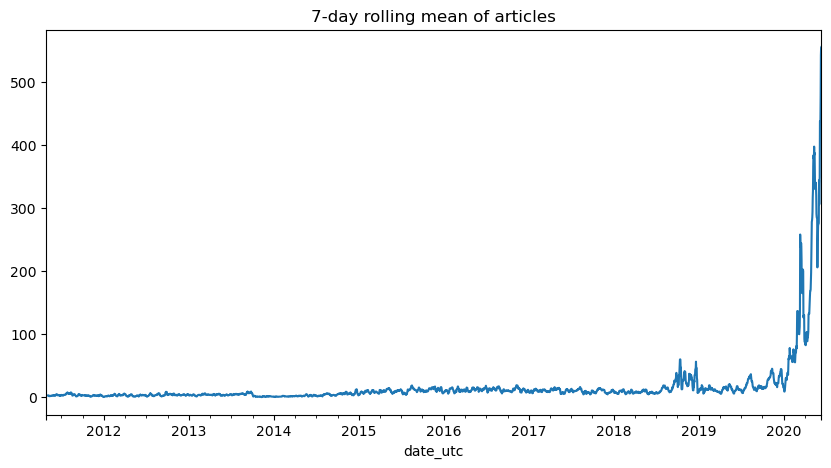

In [35]:
daily = df.set_index('date_utc').resample('D').size().rename('daily_count')
daily.rolling(7).mean().plot()
plt.title('7-day rolling mean of articles')
plt.show()


Publication times (hour of day)

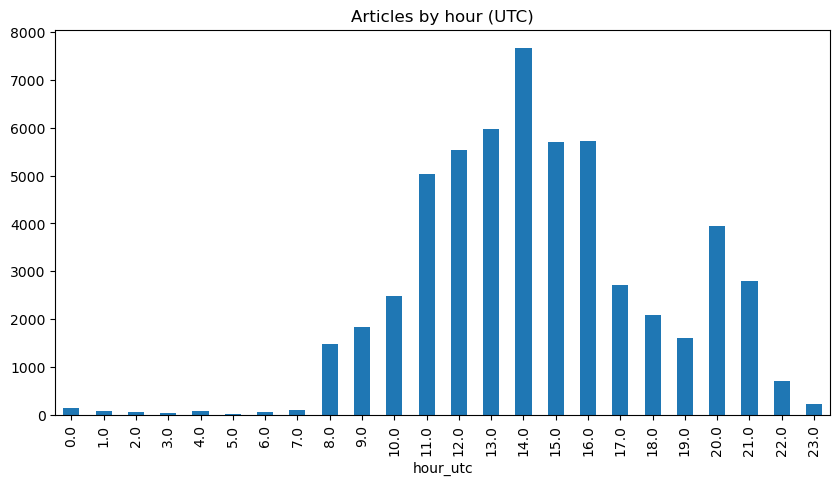

In [36]:
df['hour_utc'] = df['date_utc'].dt.hour
df['hour_utc'].value_counts().sort_index().plot(kind='bar')
plt.title('Articles by hour (UTC)')
plt.show()


Keyword extraction (TF-IDF top words)

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features=1000)
X = vect.fit_transform(df['headline'].fillna(''))
terms = vect.get_feature_names_out()
# Sum TF-IDF weights across all docs
import numpy as np
tfidf_sums = np.array(X.sum(axis=0)).ravel()
top_idx = tfidf_sums.argsort()[::-1][:30]
[(terms[i], tfidf_sums[i]) for i in top_idx]


[('stocks', np.float64(36116.14941699977)),
 ('vs', np.float64(28734.962192837054)),
 ('market', np.float64(27570.889005552483)),
 ('est', np.float64(26079.876408711418)),
 ('reports', np.float64(25168.015675798248)),
 ('earnings', np.float64(24810.640153018427)),
 ('shares', np.float64(24638.43476721431)),
 ('benzinga', np.float64(23853.13574432998)),
 ('update', np.float64(23321.745749241283)),
 ('eps', np.float64(23144.39577132824)),
 ('announces', np.float64(21033.585609882688)),
 ('downgrades', np.float64(20969.03512904805)),
 ('upgrades', np.float64(20387.377488395145)),
 ('buy', np.float64(19400.464274584232)),
 ('week', np.float64(18120.807201914533)),
 ('pt', np.float64(18075.250157389655)),
 ('sales', np.float64(17054.296941859837)),
 ('says', np.float64(16315.614811339407)),
 ('new', np.float64(15074.148044723075)),
 ('raises', np.float64(15067.901262280118)),
 ('price', np.float64(14877.03241614638)),
 ('52', np.float64(14206.060964111262)),
 ('trading', np.float64(14130.22

Publisher domain extraction (if publisher is an email)

In [40]:
df['publisher_domain'] = df['publisher'].str.extract(r'@(.+)$', expand=False)
df['publisher_domain'].value_counts().head(20)


publisher_domain
benzinga.com              7937
gmail.com                  139
andyswan.com                 5
investdiva.com               2
tothetick.com                2
eosdetroit.io                1
forextraininggroup.com       1
stockmetrix.net              1
Name: count, dtype: int64

Save summary CSVs & figures

In [42]:
import os

# Create outputs folder if it doesn't exist
os.makedirs('outputs', exist_ok=True)


In [43]:
publisher_counts.to_csv('outputs/publisher_counts.csv', index=False)
daily.reset_index().to_csv('outputs/daily_counts.csv', index=True)
